<a href="https://github.com/VUZhuangweiKang/K8sDDS/blob/main/Notebooks/throughput-parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# encoding: utf-8
# Author: Zhuangwei Kang
%matplotlib inline
import matplotlib.pyplot as plt
from datapsr import *
import numpy as np

In [42]:
plugins = ['flannel-hostgw', 'flannel-vxlan', 'kube-router', 'weavenet']

udp_plugins = ['%s-udp' % p for p in plugins]
udp_dds_secure_plugins = ['%s-dds-secure-udp' % p for p in plugins]
tcp_plugins = ['%s-tcp' % p for p in plugins]
tcp_dds_secure_plugins = ['%s-dds-secure-tcp' % p for p in plugins]
tls_plugins = ['%s-tls' % p for p in plugins]

data_len = [64, 256, 1024, 4096, 16384, 63000]

In [43]:
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['figure.figsize'] = (8, 5) 
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 12

all_colors = ['#e6194B', '#3cb44b', '#4363d8', '#f58231', '#911eb4', '#800000', '#808000', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#aaffc3', '#ffd8b1', '#000075', '#a9a9a9','#000000']
# all_colors = ['C%d' %x for x in range(10)]

In [44]:
def plotThroughput(plugins):
    # dataLen test
    throughput_perf, latency_perf = load_data(range(6), plugins)

    x_vals = np.arange(6)
    total_width, n = 0.8, len(plugins)
    width = total_width / n
    # x = x - (total_width - width) / 2

    plt.xticks(range(len(data_len)), data_len)
    plt.ylim(0, 100)
    cell_text = []
    for i, cni in enumerate(plugins):
        throughput = throughput_perf[throughput_perf['cni'] == cni]['mbps(ave)']
        cell_text.append(['%.1f' % thr for thr in throughput])
        plt.plot(x_vals, throughput, label=cni, marker='*', color=all_colors[i])
        # plt.scatter(x, thr, s=10, color=all_colors[i])

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                        rowLabels=plugins,
                        cellLoc='center',
                        rowColours=all_colors[:len(plugins)],
                        colLabels=data_len,
                        loc='bottom')
                        
    the_table.set_fontsize(15)
    the_table.scale(1, 1.5)
    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    # plt.legend()
    # plt.xlabel('dataLen(B)')
    plt.ylabel('throughput(Mbps)', fontsize=15)
    plt.xticks([])
    plt.grid(axis='y', linestyle=':')
    plt.show()

# sendQueueSize=15 for 63KB and 50 otherwise

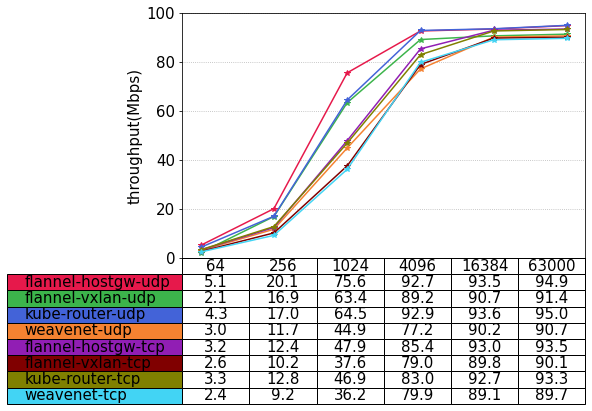

In [80]:
plotThroughput(udp_plugins + tcp_plugins)

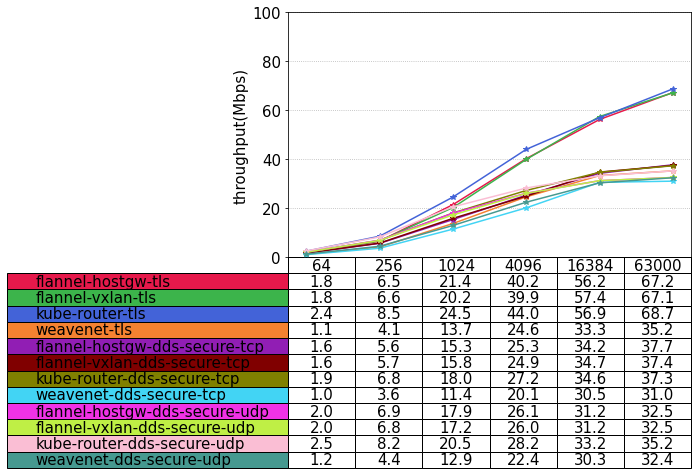

In [74]:
plotThroughput(tls_plugins + tcp_dds_secure_plugins + udp_dds_secure_plugins)

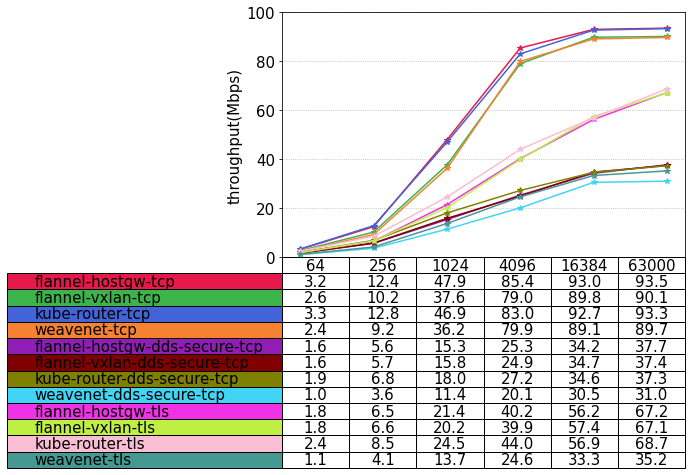

In [47]:
plotThroughput(tcp_plugins + tcp_dds_secure_plugins + tls_plugins)

In [48]:
def plotCPU(plugins):
    throughput_perf, latency_perf = load_data(range(6), plugins)
    plt.xticks(range(len(data_len)), data_len)
    for i, cni in enumerate(plugins):
        cpu = throughput_perf[throughput_perf['cni'] == cni]['cpu'] * 4
        plt.plot(np.arange(6), cpu, label=cni, marker='*', color=all_colors[i])
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', ncol=3)
    plt.xlabel('dataLen(B)')
    plt.ylabel('CPU utilization rate(%)')
    plt.grid(axis='y', linestyle=':')
    plt.show()

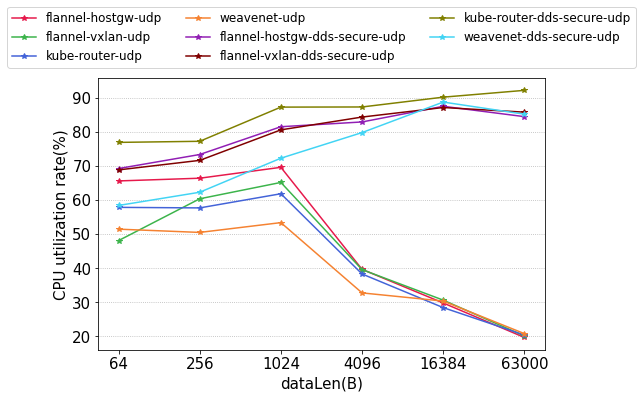

In [49]:
plotCPU(udp_plugins + udp_dds_secure_plugins)

## Test 1.3: Subscriber CPU Utilization Rate of RTI DDS Throughput Test with UDP Protocol
Conclusions:
- 

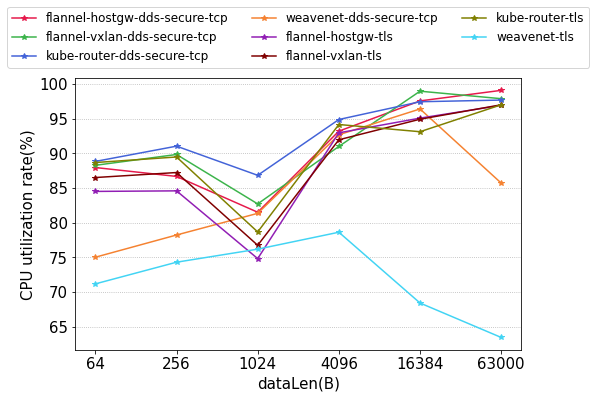

In [79]:
plotCPU(tcp_plugins + tcp_dds_secure_plugins + tls_plugins)

## Test 1.4: Subscriber CPU Utilization Rate of RTI DDS Throughput Test with TCP Protocol
Conclusions:
- 

In [51]:
def plotLoadLatency(plugins):
    throughput_perf, latency_perf = load_data(range(6), plugins)
    plt.xticks(range(len(data_len)), data_len, rotation=0)
    for i, cni in enumerate(plugins):
        lat = latency_perf[latency_perf['cni'] == cni]['90%']
        plt.plot(np.arange(6), lat, label=cni, marker='.', color=all_colors[i])
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', ncol=3)
    plt.xlabel('dataLen(B)')
    plt.ylabel('90th latency(us)')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle=':')
    plt.show()

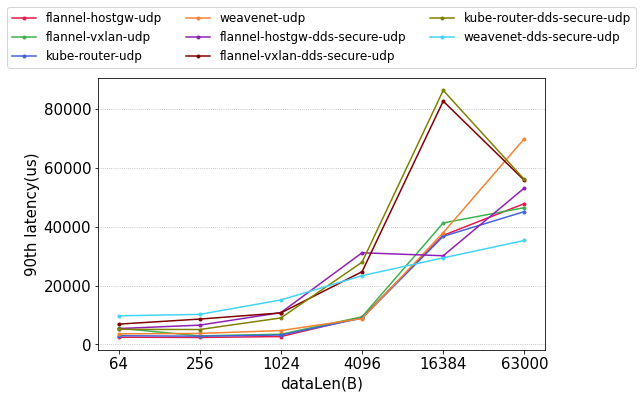

In [52]:
plotLoadLatency(udp_plugins + udp_dds_secure_plugins)

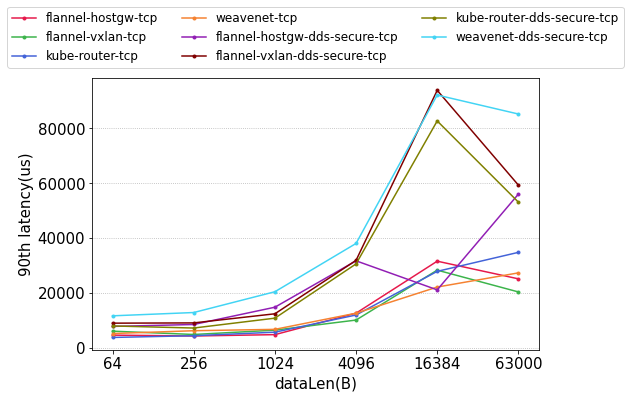

In [53]:
plotLoadLatency(tcp_plugins + tcp_dds_secure_plugins)

In [54]:
reliable_config = ['UDP-Reliable', 'UDP-BestEffort', 'TCP-Reliable', 'TCP-BestEffort']
raw_cnis = ['flannel-hostgw', 'flannel-vxlan', 'kube-router', 'weavenet', 'flannel-hostgw-dds-secure', 'flannel-vxlan-dds-secure', 'kube-router-dds-secure', 'weavenet-dds-secure']

In [55]:
# reliability test
def plotReliableThroughput():
    udp_throughput_perf, _ = load_data([6, 7], udp_plugins + udp_dds_secure_plugins)
    udp_tests = udp_throughput_perf['test'].tolist()
    cnis = udp_throughput_perf['cni'].tolist()
    to_raw_cni = lambda my_cnis: ['-'.join(c.split('-')[:-1]) for c in my_cnis]
    cnis = to_raw_cni(cnis)
    udp_throughput_perf['cni'] = cnis
    for i, t in enumerate(udp_tests[:]):
        if t == 6:
            udp_tests[i] = 'UDP-Reliable'
        else:
            udp_tests[i] = 'UDP-BestEffort'
    udp_throughput_perf['test'] = udp_tests

    tcp_throughput_perf, _ = load_data([6, 7], tcp_plugins + tcp_dds_secure_plugins)
    tcp_tests = tcp_throughput_perf['test'].tolist()
    cnis = tcp_throughput_perf['cni'].tolist()
    cnis = to_raw_cni(cnis)
    tcp_throughput_perf['cni'] = cnis
    for i, t in enumerate(tcp_tests[:]):
        if t == 6:
            tcp_tests[i] = 'TCP-Reliable'
        else:
            tcp_tests[i] = 'TCP-BestEffort'
    tcp_throughput_perf['test'] = tcp_tests

    throughput_perf = pd.concat([udp_throughput_perf, tcp_throughput_perf])
    throughput_perf = throughput_perf.reset_index(drop=True)
    
    x = np.arange(len(raw_cnis))
    plt.xticks(x, raw_cnis, rotation=30, ha='right')
    total_width, n = 0.8, len(reliable_config)
    width = total_width / n
    x = x - (total_width - width) / 2

    for i, l in enumerate(reliable_config):
        thr = []
        for cni in raw_cnis:
            tmp = throughput_perf[(throughput_perf['test'] == l) & (throughput_perf['cni'] == cni)]['mbps(ave)']
            if len(tmp) == 0:
                thr.append(0)
            else:
                thr.extend(tmp)
        plt.bar(x+i*width, thr, label=reliable_config[i], width=width)

    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=4)
    # plt.xlabel('cni')
    plt.ylabel('throughput(Mbps)')
    plt.grid(axis='y', linestyle=':')
    plt.show()

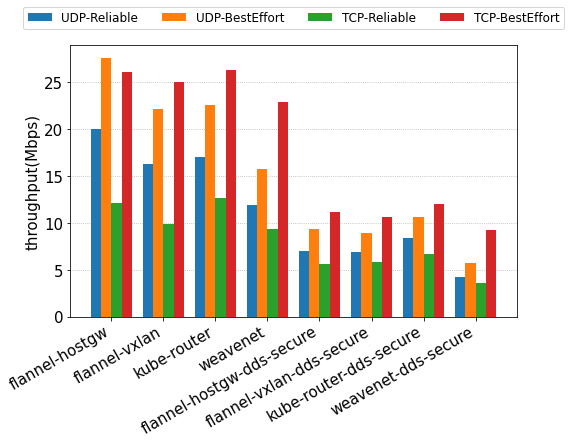

In [56]:
plotReliableThroughput()

## Reliability Test
Conclusion:
- 

In [57]:
def plotBestEffortThroughput(plugins):
    throughput_perf, latency_perf = load_data([7], plugins)
    # reliability test
    x = np.arange(len(plugins))
    plt.xticks(x, plugins, rotation=30, ha='right')
    plt.bar(x, throughput_perf['mbps(ave)'])

    plt.ylabel('mbps(ave)')
    plt.grid(axis='y', linestyle=':')
    plt.show()

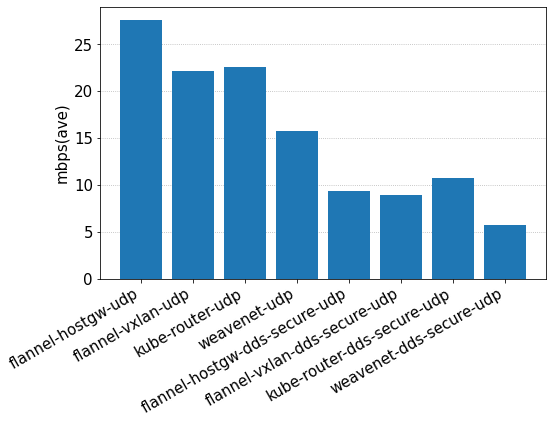

In [58]:
plotBestEffortThroughput(udp_plugins + udp_dds_secure_plugins)

In [59]:
multisub_tests = [6, 8, 9, 10]
num_subs = [1,2,4,8]

In [60]:
def plotMultiSubThroughput(plugins):
    # numSubscriber unicast test
    throughput_perf, _ = load_data(multisub_tests, plugins)

    x = np.arange(4)
    total_width, n = 0.8, len(plugins)
    width = total_width / n
    # x = x - (total_width - width) / 2

    plt.xticks(x, num_subs, rotation=0)
    for i, cni in enumerate(plugins):
        thr = throughput_perf[throughput_perf['cni'] == cni]['mbps(ave)']
        plt.plot(x, thr, label=cni, marker='.', color=all_colors[i])
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', ncol=3)
    plt.xlabel('numSubscribers')
    plt.ylabel('unicast throughput(Mbps)')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle=':')
    plt.show()

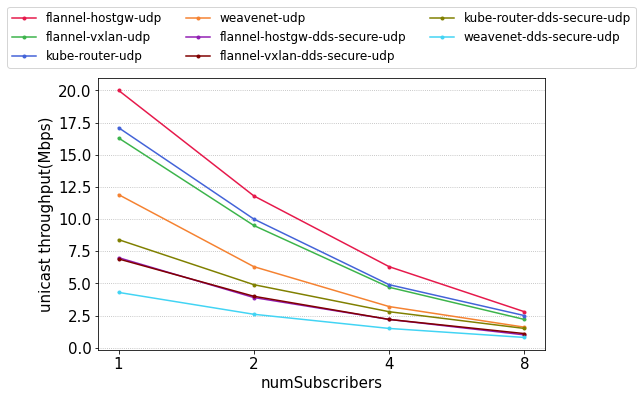

In [61]:
plotMultiSubThroughput(udp_plugins + udp_dds_secure_plugins)

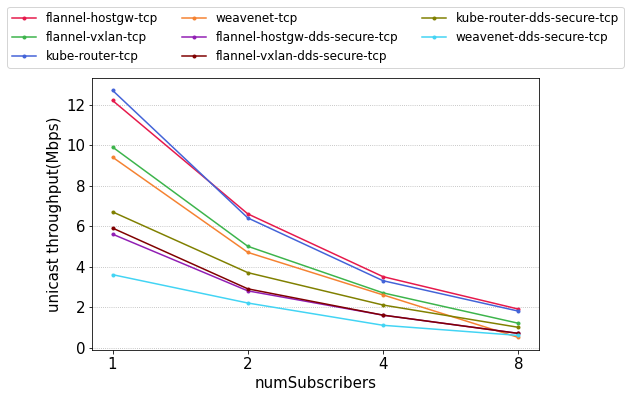

In [62]:
plotMultiSubThroughput(tcp_plugins + tcp_dds_secure_plugins)

In [63]:
def plotMultiSubLatency(plugins):
    # numSubscriber unicast test
    _, latency_perf = load_data(multisub_tests, plugins)
    x = np.arange(4)
    plt.xticks(x, num_subs, rotation=0)
    for i, cni in enumerate(plugins):
        lat = latency_perf[latency_perf['cni'] == cni]['90%']
        plt.plot(x, lat, label=cni, marker='.', color=all_colors[i])
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', ncol=3)
    plt.xlabel('numSubscribers')
    plt.ylabel('90th latency(us)')
    plt.grid(axis='y', linestyle=':')
    plt.show()

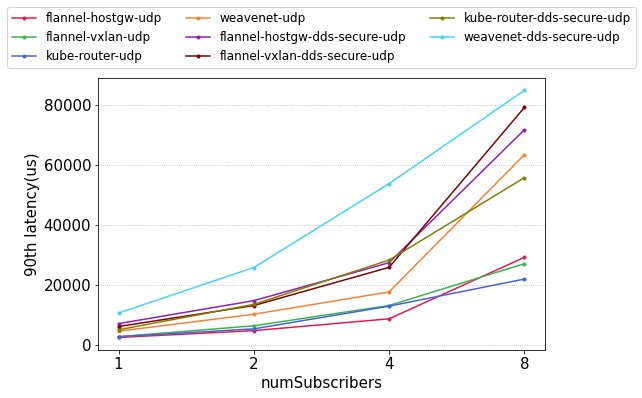

In [64]:
plotMultiSubLatency(udp_plugins + udp_dds_secure_plugins)

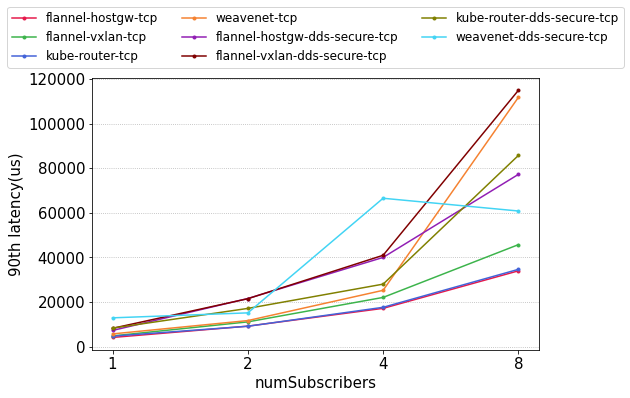

In [65]:
plotMultiSubLatency(tcp_plugins + tcp_dds_secure_plugins)

In [66]:
def plotBatchingThroughput(plugins):
    # batching test
    udp_throughput_perf, _ = load_data([11], udp_plugins + udp_dds_secure_plugins)
    to_raw_cni = lambda my_cnis: ['-'.join(c.split('-')[:-1]) for c in my_cnis]
    udp_throughput_perf['cni'] = to_raw_cni(udp_throughput_perf['cni'])
    udp_throughput_perf['test'] = 'UDP'

    tcp_throughput_perf, _ = load_data([11], tcp_plugins + tcp_dds_secure_plugins)
    tcp_throughput_perf['cni'] = to_raw_cni(tcp_throughput_perf['cni'])
    tcp_throughput_perf['test'] = 'TCP'

    throughput_perf = pd.concat([udp_throughput_perf, tcp_throughput_perf])
    throughput_perf = throughput_perf.reset_index()

    x = np.arange(len(raw_cnis))
    total_width, n = 0.8, 2
    width = total_width / n
    x = x - (total_width - width) / 2

    labels = ['UDP', 'TCP']
    plt.xticks(range(len(plugins)), raw_cnis, rotation=30, ha='right')
    plt.ylim(0, 100)
    for i, l in enumerate(labels):
        thr = []
        for cni in raw_cnis:
            tmp = throughput_perf[(throughput_perf['test'] == l) & (throughput_perf['cni'] == cni)]['mbps(ave)']
            if len(tmp) == 0:
                thr.append(0)
            else:
                thr.extend(tmp)
        plt.bar(x+i*width, thr, label=labels[i], width=width)

    plt.grid(axis='y')
    plt.legend()
    plt.ylabel('throughput(Mbps)')
    plt.grid(axis='y', linestyle=':')
    plt.show()

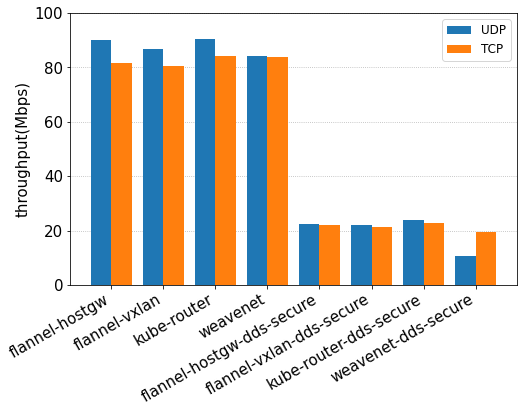

In [67]:
plotBatchingThroughput(udp_plugins + udp_dds_secure_plugins)

In [68]:
multicast_plugins = ['weavenet-udp', 'weavenet-encryption-udp', 'weavenet-dds-secure-udp', 'hostnetwork-udp']
multicast_test = [12,13,14,15]

In [69]:
def plotMulticastThroughput():
    # multicast test
    throughput_perf, _ = load_data(multicast_test,  multicast_plugins)

    num_subs = [1,2,4,8]
    x = np.arange(4)
    total_width, n = 0.8, len(multicast_plugins)
    width = total_width / n
    # x = x - (total_width - width) / 2

    plt.xticks(x, num_subs, rotation=0)
    for i, cni in enumerate(multicast_plugins):
        thr = throughput_perf[throughput_perf['cni'] == cni]['mbps(ave)']
        plt.plot(x, thr, label=cni, marker='*', color=all_colors[i])
    plt.legend(bbox_to_anchor=(0.5, 1.12), loc='center', ncol=2)
    plt.xlabel('numSubscribers')
    plt.ylabel('multicast throughput(Mbps)')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle=':')
    plt.show()

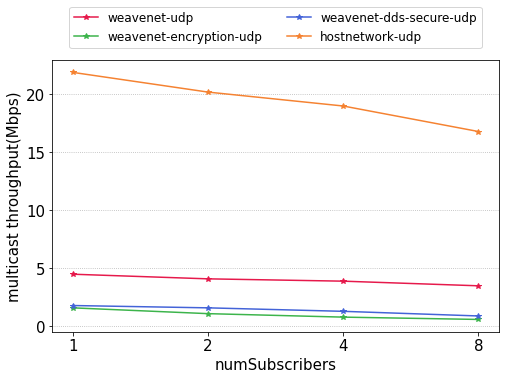

In [70]:
plotMulticastThroughput()

In [71]:
def plotMulticastLatency():
    # multicast test
    _, latency_perf = load_data(multicast_test,  multicast_plugins)
    num_subs = [1,2,4,8]
    x = np.arange(4)
    total_width, n = 0.8, len(multicast_plugins)
    width = total_width / n

    plt.xticks(x, num_subs, rotation=0)
    for i, cni in enumerate(multicast_plugins):
        thr = latency_perf[latency_perf['cni'] == cni]['90%']
        plt.plot(x, thr, label=cni, marker='.', color=all_colors[i])
    plt.legend(bbox_to_anchor=(0.5, 1.12), loc='center', ncol=2)
    plt.xlabel('numSubscribers')
    plt.ylabel('90th latency(us)')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle=':')
    plt.show()

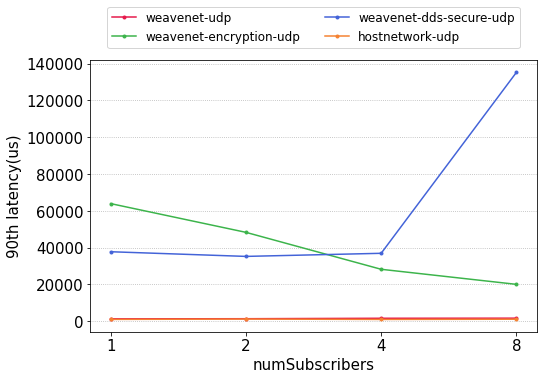

In [72]:
plotMulticastLatency()